In [49]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/Users/adnan/Documents/datasets/brain_tumor_classification/Training/',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2870 files belonging to 4 classes.


In [50]:
class_names = train_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


2024-06-01 21:10:18.920063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


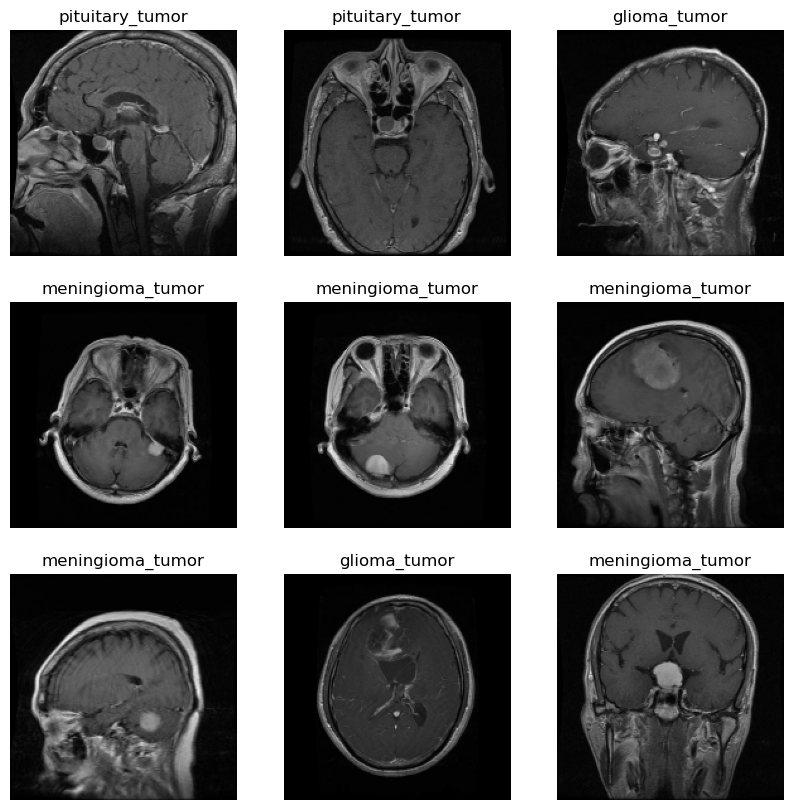

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [52]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/Users/adnan/Documents/datasets/brain_tumor_classification/Validation/',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 394 files belonging to 4 classes.


In [53]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [54]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [55]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,156 (15.22 MB)

 Trainable params: 3,989,156 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
training_history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - accuracy: 0.5444 - loss: 1.0278 - val_accuracy: 0.4619 - val_loss: 1.7417
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.8005 - loss: 0.4926 - val_accuracy: 0.6142 - val_loss: 2.2889
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.9078 - loss: 0.2580 - val_accuracy: 0.6320 - val_loss: 2.7917
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.9397 - loss: 0.1750 - val_accuracy: 0.6878 - val_loss: 3.6172
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.9791 - loss: 0.0651 - val_accuracy: 0.6954 - val_loss: 3.4566
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.9826 - loss: 0.0629 - val_accuracy: 0.6726 - val_loss: 5.0888
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - accuracy: 0.9962 - loss: 0.0206 - val_accuracy: 0.7411 - val_loss: 5.1509
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - accuracy: 0.9946 - loss: 0.0197 - val_accu

2024-06-01 21:13:05.303751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


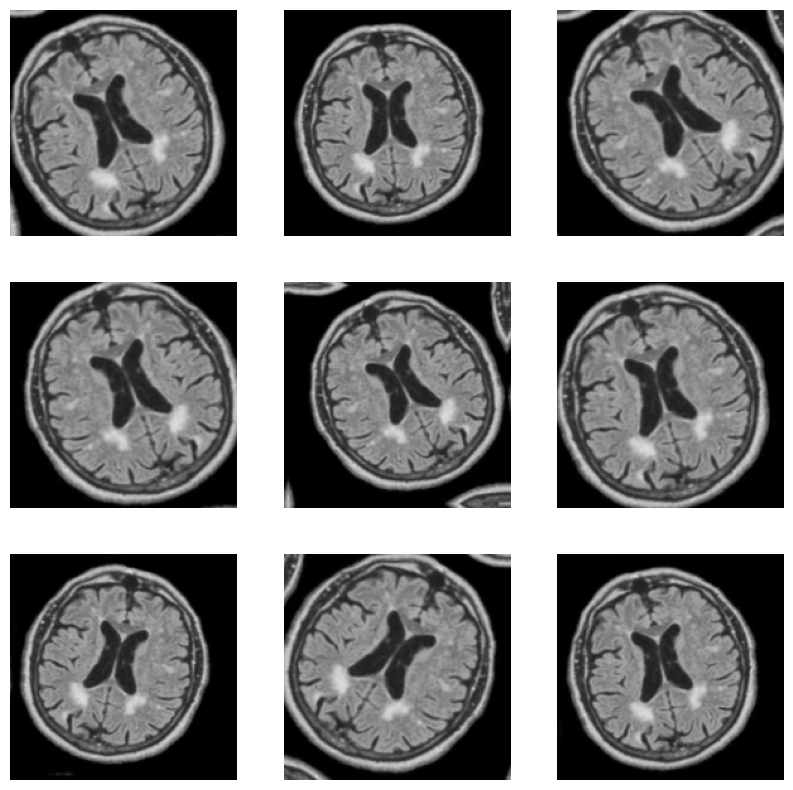

In [58]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [59]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [60]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [61]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [62]:
epochs = 16
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/16
90/90 ━━━━━━━━━━━━━━━━━━━━ 23s 252ms/step - accuracy: 0.4529 - loss: 1.2527 - val_accuracy: 0.3020 - val_loss: 1.7313
Epoch 2/16
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.6475 - loss: 0.8515 - val_accuracy: 0.3528 - val_loss: 1.8958
Epoch 3/16
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.7091 - loss: 0.7181 - val_accuracy: 0.4010 - val_loss: 2.0025
Epoch 4/16
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.7308 - loss: 0.6394 - val_accuracy: 0.4695 - val_loss: 2.1007
Epoch 5/16
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.7738 - loss: 0.5686 - val_accuracy: 0.5025 - val_loss: 2.2122
Epoch 6/16
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.7617 - loss: 0.5571 - val_accuracy: 0.4518 - val_loss: 2.2144
Epoch 7/16
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.7932 - loss: 0.5225 - val_accuracy: 0.5609 - val_loss: 2.2189
Epoch 8/16
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 167ms/step - accuracy: 0.8218 - loss: 0.4403 - val_accu

In [66]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import tensorflow as tf

# Define the local path to the image and the target size
local_image_path = '/Users/adnan/Desktop/Te-pi_0015.jpg'

# Load the image from the local path
img = load_img(local_image_path, target_size=(img_height, img_width))

# Convert the image to an array
img_array = img_to_array(img)

# Expand the dimensions to create a batch
img_array = np.expand_dims(img_array, axis=0)

# Make predictions using the model
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Print the result with the most likely class and confidence
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
This image most likely belongs to pituitary_tumor with a 99.30 percent confidence.
